# ParSNIP classification demo

This notebook demonstrates how ParSNIP can be used to classify transients. ParSNIP produces a redshift-independent representation of transients, so unlike most previous methods it is not highly sensitive to the redshift distribution of transients in the training set.

In this notebook, we train a classifier using the mean and uncertainty on the intrinsic latent variables, luminosity and color predicted by the ParSNIP model along with the uncertainty on the reference time. We do this for both the PS1 and PLAsTiCC datasets, and compare with predictions from the Avocado model.

# Load dependencies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.table import Table

import parsnip

# Classifications for the PS1 dataset

In [2]:
raw_predictions = Table.read('../predictions/parsnip_predictions_ps1_aug_100.h5')

# Only keep predictions for objects in the supervised sample
predictions_ps1 = raw_predictions[raw_predictions['supervised']].copy()

# This is a dataset containing both augmented and original objects.
# Make a mask to pull out the original objects.
original_mask_ps1 = ~predictions_ps1['augmented']

## All classes

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
[100]	valid_0's multi_logloss: 0.300127
[100]	valid_0's multi_logloss: 1.01522
[100]	valid_0's multi_logloss: 0.386745
[100]	valid_0's multi_logloss: 0.849632
[100]	valid_0's multi_logloss: 0.386095
[100]	valid_0's multi_logloss: 0.903243
[100]	valid_0's multi_logloss: 0.474693
[100]	valid_0's multi_logloss: 0.512012
[100]	valid_0's multi_logloss: 0.285442
[100]	valid_0's multi_logloss: 1.40803
Macro averaged completeness (Villar et al. 2020): 0.7888
Fraction correct: 0.8923


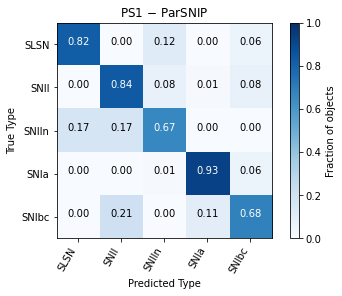

In [3]:
classifier_ps1 = parsnip.Classifier()
classifications_ps1 = classifier_ps1.train(predictions_ps1)
parsnip.plot_confusion_matrix(predictions_ps1[original_mask_ps1], classifications_ps1[original_mask_ps1],
                              title='PS1 $-$ ParSNIP')
plt.savefig('./figures/ps1_confusion_matrix.pdf')

## SNIa vs all others

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
[100]	valid_0's binary_logloss: 0.0810243
[100]	valid_0's binary_logloss: 0.123652
[100]	valid_0's binary_logloss: 0.11551
[100]	valid_0's binary_logloss: 0.129573
[100]	valid_0's binary_logloss: 0.202632
[100]	valid_0's binary_logloss: 0.0638458
[100]	valid_0's binary_logloss: 0.171498
[100]	valid_0's binary_logloss: 0.257643
[100]	valid_0's binary_logloss: 0.110191
[100]	valid_0's binary_logloss: 0.179153
Macro averaged completeness (Villar et al. 2020): 0.9561
Fraction correct: 0.9569


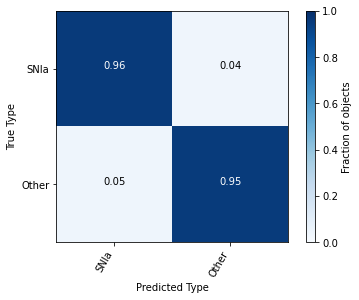

In [4]:
classifier_ps1_ia = parsnip.Classifier()
classifications_ps1_ia = classifier_ps1_ia.train(predictions_ps1, target_label='SNIa')
parsnip.plot_confusion_matrix(predictions_ps1[original_mask_ps1], classifications_ps1_ia[original_mask_ps1])

# Classifications for the PLAsTiCC dataset

## Generate ParSNIP classifications

In [5]:
predictions_plasticc_train = Table.read('../predictions/parsnip_predictions_plasticc_train_aug_100.h5')
predictions_plasticc_test = Table.read('../predictions/parsnip_predictions_plasticc_test.h5')

In [6]:
classifier_plasticc = parsnip.Classifier()
classifications_plasticc_train = classifier_plasticc.train(predictions_plasticc_train)

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
[100]	valid_0's multi_logloss: 0.524034
[100]	valid_0's multi_logloss: 0.525304
[100]	valid_0's multi_logloss: 0.544961
[100]	valid_0's multi_logloss: 0.564758
[100]	valid_0's multi_logloss: 0.462797
[100]	valid_0's multi_logloss: 0.527013
[100]	valid_0's multi_logloss: 0.55661
[100]	valid_0's multi_logloss: 0.487204
[100]	valid_0's multi_logloss: 0.499258
[100]	valid_0's multi_logloss: 0.544764


In [7]:
classifications_plasticc_test = classifier_plasticc.classify(predictions_plasticc_test)

## Load Avocado classifications (must rerun avocado to generate)

In [8]:
# Load Avocado classifications
# NOTE: these were run with a modified version of Avocado that uses the true redshift
# instead of photometric redshifts.
classifications_avocado = pd.read_hdf('../predictions/predictions_plasticc_test_true_redshift.h5', key='predictions')

# Rename columns
label_map = {
    90: 'SNIa',
    67: 'SNIa-91bg',
    52: 'SNIax',
    42: 'SNII',
    62: 'SNIbc',
    95: 'SLSN-I',
    15: 'TDE',
    64: 'KN',
    88: 'AGN',
    92: 'RRL',
    65: 'M-dwarf',
    16: 'EB',
    53: 'Mira',
    6: 'uLens-Single',
    991: 'uLens-Binary',
    992: 'ILOT',
    993: 'CaRT',
    994: 'PISN',
}
classifications_avocado.rename(columns=label_map, inplace=True)

# Select the same subset of columns and rows as we used for Parsnip
plasticc_object_ids = np.array([i.lower().replace(' ', '_') for i in predictions_plasticc_test['object_id']])
classifications_avocado = classifications_avocado.loc[plasticc_object_ids, classifications_plasticc_test.colnames[1:]]

# Renormalize classification probabilities
classifications_avocado = classifications_avocado.div(classifications_avocado.sum(axis=1), axis=0)

# Convert to an astropy Table
classifications_avocado = Table.from_pandas(classifications_avocado, index=True)

## Confusion matrices

Macro averaged completeness (Villar et al. 2020): 0.8130
Fraction correct: 0.8007


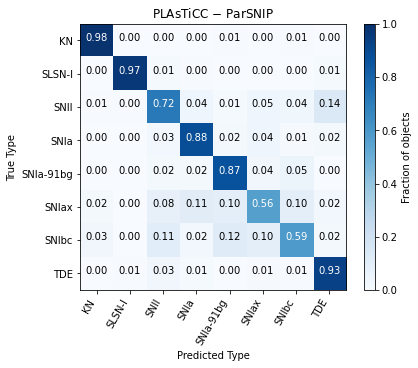

In [9]:
parsnip.plot_confusion_matrix(predictions_plasticc_test, 
                              classifications_plasticc_test, 
                              figsize=(6, 5), title='PLAsTiCC $-$ ParSNIP')
plt.savefig('./figures/plasticc_parsnip_confusion_matrix.pdf')

Macro averaged completeness (Villar et al. 2020): 0.7828
Fraction correct: 0.7852


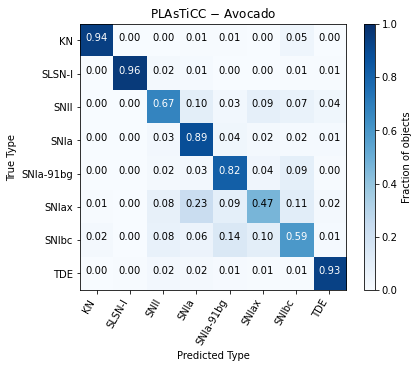

In [10]:
parsnip.plot_confusion_matrix(predictions_plasticc_test, classifications_avocado, 
                              figsize=(6, 5), title='PLAsTiCC $-$ Avocado')
plt.savefig('./figures/plasticc_avocado_confusion_matrix.pdf')

## Evaluate the PLAsTiCC metric (Malz et al. 2019)

In [11]:
mask = np.isin(predictions_plasticc_test['type'],
               np.char.encode(classifications_plasticc_test.colnames[1:]))
avocado_metric = parsnip.weighted_multi_logloss(predictions_plasticc_test['type'][mask],
                                                classifications_avocado[mask])
print(f"Avocado: {avocado_metric:.4f}")
parsnip_metric = parsnip.weighted_multi_logloss(predictions_plasticc_test['type'][mask],
                                                classifications_plasticc_test[mask])
print(f"ParSNIP: {parsnip_metric:.4f}")

Avocado: 0.5986
ParSNIP: 0.5353


## AUC/ROC Curves

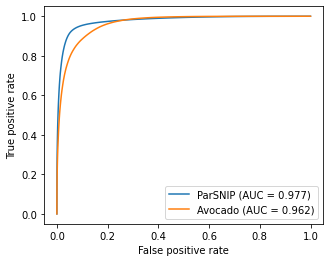

In [12]:
# Show the ROC curve for SN Ia classification
from sklearn.metrics import roc_curve, auc

target = 'SNIa'

plt.figure(figsize=(5, 4))
fpr1, tpr1, thresholds = roc_curve(predictions_plasticc_test['type'] == target, classifications_plasticc_test[target])
plt.plot(fpr1, tpr1, label=f'ParSNIP (AUC = {auc(fpr1, tpr1):.3f})')
fpr2, tpr2, thresholds = roc_curve(predictions_plasticc_test['type'] == target, classifications_avocado[target])
plt.plot(fpr2, tpr2, label=f'Avocado (AUC = {auc(fpr2, tpr2):.3f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()

plt.savefig('./figures/plasticc_snia_roc.pdf')

In [13]:
# Look at the improvement in false positive rate for different true positive rates
for cutoff in np.arange(0.1, 1, 0.1):
    f1 = fpr1[np.where(tpr1 > cutoff)[0][0]]
    f2 = fpr2[np.where(tpr2 > cutoff)[0][0]]
    print(f'{cutoff:.1f} {f1:.5f} {f2:.5f} {f2 / f1}')

0.1 0.00006 0.00021 3.77027027027027
0.2 0.00035 0.00110 3.105263157894737
0.3 0.00110 0.00289 2.63716814159292
0.4 0.00241 0.00591 2.45724907063197
0.5 0.00444 0.01036 2.3316557624559637
0.6 0.00766 0.01754 2.2878684696954954
0.7 0.01265 0.02948 2.3307003065314786
0.8 0.02184 0.05292 2.4233960460272477
0.9 0.04350 0.11362 2.6122844310350737


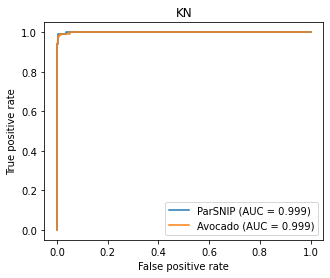

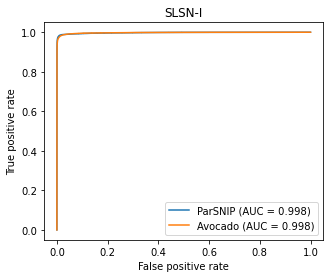

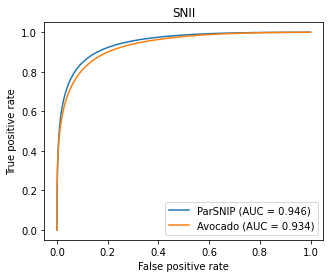

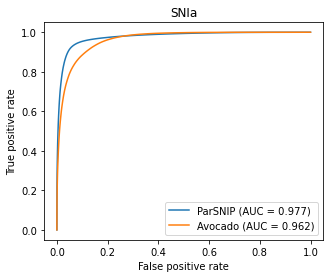

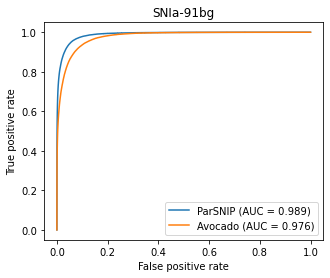

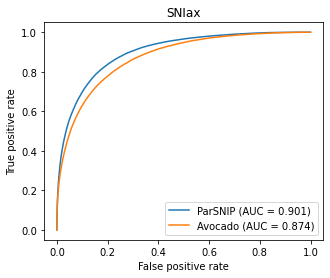

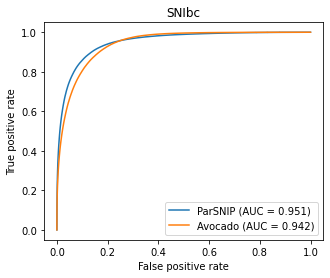

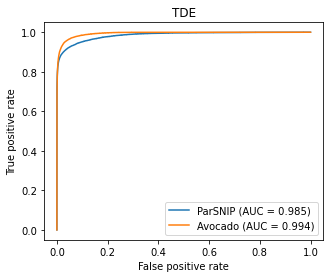

In [14]:
# Show the ROC curves for all targets
from sklearn.metrics import roc_curve, auc

for target in classifications_plasticc_test.colnames[1:]:
    plt.figure(figsize=(5, 4))
    fpr1, tpr1, thresholds = roc_curve(predictions_plasticc_test['type'] == target, classifications_plasticc_test[target])
    plt.plot(fpr1, tpr1, label=f'ParSNIP (AUC = {auc(fpr1, tpr1):.3f})')
    fpr2, tpr2, thresholds = roc_curve(predictions_plasticc_test['type'] == target, classifications_avocado[target])
    plt.plot(fpr2, tpr2, label=f'Avocado (AUC = {auc(fpr2, tpr2):.3f})')

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.legend()
    plt.title(target)

## Redshift dependent AUC

In [15]:
def plot_auc(target, pred, key, label, num_bins=100, binrange=None):
    val = predictions_plasticc_test[key]

    xvals = []
    aucs = []

    if binrange is None:
        bins = np.linspace(0, 100, num_bins+1)
    else:
        bins = np.linspace(binrange[0], binrange[1], num_bins+1)
        
    for bin_idx in range(num_bins):
        if binrange is None:
            cut = (val >= np.percentile(val, bins[bin_idx])) & (val < np.percentile(val, bins[bin_idx + 1]))
        else:
            cut = (val > bins[bin_idx]) & (val < bins[bin_idx + 1])

        fpr, tpr, thresholds = roc_curve(target[cut], pred[cut])
        aucs.append(auc(fpr, tpr))

        xvals.append(np.mean(val[cut]))

    plt.plot(xvals, aucs, label=label)
    plt.xlabel(key)
    plt.ylabel('AUC')
    plt.legend()

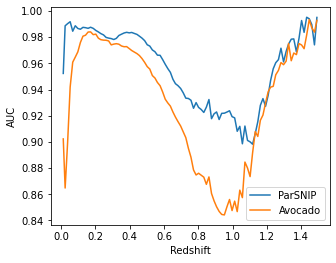

In [16]:
plt.figure(figsize=(5, 4))

key = 'redshift'

plot_class = 'SNIa'
plot_auc(predictions_plasticc_test['type'] == plot_class, classifications_plasticc_test[plot_class], key, 'ParSNIP', binrange=(0, 1.5))
plot_auc(predictions_plasticc_test['type'] == plot_class, classifications_avocado[plot_class], key, 'Avocado', binrange=(0, 1.5))

plt.xlabel('Redshift')
plt.ylabel('AUC')

plt.savefig('./figures/auc_redshift.pdf')